In [48]:
import pandas as pd
import arrow as ar
input_path = "/Users/dongjian/data/meituanKaggleData/"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

nans = lambda df: df[df.isnull().any(axis=1)]
to_drop = ['order_unix_time', 'arriveshop_unix_time', 'fetch_unix_time', 'finish_unix_time', 'order_id',
           'delivery_duration', 'date', "arriveshop_cost", "fetch_cost", "arrive_guest_cost", "tmp_order_unix_time",
           "coor_count_y", "coor_count_x",
           "coor_count",
           "avg_speed", "arrive_guest_avg_speed", 'high', 'day', "coor_count_x.1", "coor_count_y.1", "coor_count_y.2",
           'coor_count_x.2',
           "rain_bin", "wind_bin", "temperature_bin"
           ]

fea_drop = [
    "_10min_wind",
    # "area_id",
    "poi_id_mean_box_total_value",
    # "box_total_value",
    # "food_num",
    "_10min_rain",
    "weekday_hour",
    "_avg_speed_weekday",
    "minute",
    "_10min_temperature",
    "hour",
    "pickup_cluster",
    "dropoff_cluster",
    "next15_min",
    "cur_min_x",
    "cur_min_y",
    "cur_min",
    "next5_min",
    "next10_min",
    "next15_min",
    "cur_10_block",
    "cur_10_block_y.2",
    "cur_10_block_y.1",
    "cur_10_block_y",
    "cur_10_block_x",
    "cur_10_block_x.2",
    "cur_10_block_x.1",
    "last_10_block",
    "next_10_block",
    "area_id_y",
    "area_id_x",
    'weekday',
    "poi_agg__box_total_value__median_by__poi_id",
    "lasthour_poi_agg__box_total_value__median_by__poi_id",
    "lasthour_poi_agg__waiting_order_num__median_by__poi_id",
    "food_num"

    # "dropoff_cluster",
    # "delivery_distance",
    # "_10min_deliverying_order_num"
    # "poi_lat_bin","poi_lng_bin","cst_lat_bin","cst_lng_bin"
    # "poi_id",
    # "weekday",
    # "food_num",
    # "lasthour_poi_agg_poi_id_mean_delivery_distance"
]  # 407.263830991 all 400


# features = list((set(basic_features) | set(advanced_features)) - set(to_drop) - set(fea_drop))


# features = single_feas


def generate_tgt(inp_features, tgt):
    to_do = set(inp_features) - set(to_drop) - set(fea_drop)
    return filter(lambda x: x, map(lambda x: x if x.startswith(tgt) else None, list(to_do)))


def generate_base():
    return list(
            set(["order_id", "poi_id", "area_id", "food_total_value", "box_total_value", "food_num",
                 "delivery_distance", "order_unix_time", "arriveshop_unix_time", "fetch_unix_time", "finish_unix_time",
                 "customer_longitude", "customer_latitude", "poi_lng", "poi_lat", "waiting_order_num",
                 "delivery_duration", "tmp_order_unix_time", "day", "weekday", "hour", "10min", "15min", "cur_min",
                 "next5_min", "next10_min", "cur_10_block", "last_10_block", "next_10_block", "minute", "high",
                 "weekday_hour", "_10min_not_fetched_order_num", "_10min_working_rider_num",
                 "_10min_notbusy_working_rider_num", "_10min_deliverying_order_num", "_10min_rain",
                 "_10min_temperature", "_10min_wind", "area_busy_coef", "bill_number_per_rider", "avg_speed",
                 "direction", "poi_lat_bin", "poi_lng_bin", "cst_lat_bin", "cst_lng_bin", "arriveshop_cost",
                 "fetch_cost", "arrive_guest_cost", "arrive_guest_avg_speed", "pickup_cluster",
                 "dropoff_cluster", "prd_arrive_guest_time"]) - set(to_drop) - set(fea_drop))


def init_arguments():
    parser = argparse.ArgumentParser()

    parser.add_argument('--label', type=str, dest='label',
                        help="data")

    parser.add_argument('--train', type=str, dest='train_path',
                        help="data")
    parser.add_argument('--test', type=str, dest='test_path',
                        help="data")
    parser.add_argument('--round', type=int, dest='round',
                        help="data", default=500)

    parser.add_argument('--output', type=str, dest='out_path',
                        help="data")
    return parser.parse_args()


import random


def gene_xtrain(train, tgt_list, remove=None):
    features = list(set(train.columns.tolist()[1:]) - set(to_drop) - set(fea_drop))
    rs = []
    for i in tgt_list:
        if i == "base":
            rs += generate_base()
        else:
            rs += generate_tgt(features, i)

    if remove:
        for r in remove:
            rs = filter(lambda x: r not in x, rs)
    # print rs
    return rs

def gene_mask(df, h, high=False):
    base = (df.delivery_duration < 4654.0) & (df.delivery_duration > 663.0) & \
           (df.delivery_distance > 10)  # ???
    if high:
        return base & (df.high.values == 1)
    else:
        return base & ((df.hour.values == h) | (df.hour.values == h + 6))
    
def load_order_data(file_name, sep=","):
    df = pd.read_csv('%s' % file_name, sep)
    names = map(lambda x: x.replace("algocamp_order_test.", ""), df.columns.tolist())

    df.columns = names
    # df.rename(columns=names,inplace=True)
    c = 'order_unix_time'
    mask = pd.notnull(df[c])
    df.loc[mask, "tmp_order_unix_time"] = df.loc[mask, c]
    df.loc[mask, c] = df.loc[mask, c].apply(lambda x: ar.get(x).to("local"))
    df.loc[mask, 'day'] = df.loc[mask, c].apply(lambda x: x.day)
    df.loc[mask, 'weekday'] = df.loc[mask, c].apply(lambda x: x.weekday())
    df.loc[mask, 'hour'] = df.loc[mask, c].apply(lambda x: x.hour)
    df.loc[mask, '10min'] = df.loc[mask, c].apply(lambda x: x.minute / 10)
    df.loc[mask, '15min'] = df.loc[mask, c].apply(lambda x: x.minute / 15)
    df.loc[mask, 'minute'] = df.loc[mask, c].apply(lambda x: x.minute)
    df.loc[mask, 'high'] = df.loc[mask, c].apply(lambda x: 1 if x.hour in (11, 12, 13, 17, 18, 19) else 0)
    df.loc[mask, 'weekday_hour'] = df.loc[mask, c].apply(lambda x: x.weekday() * 24 + x.hour)
    df.loc[mask, c] = df.loc[mask, "tmp_order_unix_time"]
    return df

def getPctMissing(series):
    num = series.isnull().sum()
    den = series.count()
    return 100 * (num / den)


def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'missing_values', 1: 'missing_percent'})
    return mis_val_table_ren_columns



In [111]:
# train_sub = pd.read_csv(input_path+"train_sub.csv",sep=',')
# test_sub = pd.read_csv(input_path+"test_sub.csv",sep=',')

# train_cv = pd.read_csv(input_path+"train_cv.csv",sep=',')
# test_cv = pd.read_csv(input_path+"test_cv.csv",sep=',')
out_restack = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/out.csv")
# out_restack = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/out_lgb.csv")

# out_restack = pd.read_csv(input_path+"out.csv",sep=',')

# out_restack = pd.read_csv(input_path+"out_256.csv",sep=',')
# out_1024 = pd.read_csv(input_path+"out_1024.csv",sep=',')
# out_64 = pd.read_csv(input_path+"out_64.csv",sep=',')
# a = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/stack_data/train2018.csv")
# try_28 = pd.read_csv(input_path+"try_28.csv",sep=',')

# out = out_256.merge(out_1024,on="order_id",how='inner').merge(out_64,on="order_id",how='inner')

# out_restack.describe()
# test_cv = load_order_data(input_path+"waybill_info_test_a.csv",sep='\t')

In [103]:
out = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/out.csv")
out1 = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/out1.csv")
out2 = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/out2.csv")
out3 = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/out3.csv")


In [104]:
out['delivery_duration'] = (out['delivery_duration']+out1['delivery_duration']*2+out2['delivery_duration']*2+out3['delivery_duration'])/6

In [105]:
out.describe()

,delivery_duration,order_id
count,251864.000000,2.518640e+05
mean,2239.342452,1.502431e+15
std,652.578534,5.682584e+11
min,1045.071190,1.501470e+15
25%,1711.971413,1.501926e+15
50%,2155.549401,1.502422e+15
75%,2706.953582,1.502940e+15
max,4050.096377,1.503397e+15


In [229]:
def get_stats_target(df, group_column, target_column_list,tgt_stats=['mean', 'median', 'max', 'min', 'std'], prefix="hehe",drop_count=True, drop_raw_col=True, filter_count=10):
    df_old = df.copy()
    grouped = df_old.groupby(group_column)
    grouped.order_id.count()
    rs = []
    for target_column in target_column_list:
        def gene_col_names(stat):
            return '{}__{}__{}_by__{}'.format(prefix, target_column, stat,"#".join(group_column))

        the_stats = grouped[target_column].agg(tgt_stats).reset_index()
        print the_stats.columns
        the_stats.columns = group_column + map(gene_col_names,tgt_stats)
        if drop_raw_col:
            the_stats.drop(group_column, axis=1, inplace=True)
        rs.append(the_stats)

    count = grouped["order_id"].agg(['count']).reset_index()
    count_col_name = '{}__{}__{}_by__{}'.format(prefix, "order_id", "count","#".join(group_column))
    count.columns = group_column + [count_col_name]
    agg_rs = pd.concat(rs + [count], axis=1)
    af_flt = agg_rs[agg_rs[count_col_name] >= filter_count]

    print "group column is {},agg total count is {}; after filter , agg total count is {}, filter ratio is {} %". \
        format("#".join(group_column),len(agg_rs), len(af_flt),
               (1 - len(af_flt) / (len(agg_rs) + 0.01))*100)

    if drop_count:
        return af_flt[[x for x in af_flt.columns if "count" not in x]]
    else:
        return af_flt

def get_rolling_target(df, group_column, target_column_list, prefix="hehe", drop_raw_col=False):
    df_old = df.copy()
    grouped = df_old.groupby(group_column)
    rs = []
    for target_column in target_column_list:
#         print grouped[target_column].head(5)
        the_stats = [
            grouped[target_column].apply(lambda x:x.rolling(5).mean().shift(-5)),
            grouped[target_column].apply(lambda x:x.rolling(5).std().shift(-5)),
            grouped[target_column].apply(lambda x:x.rolling(5).sum().shift(-5)),
            grouped[target_column].apply(lambda x:x.rolling(5).mean().shift()),
            grouped[target_column].apply(lambda x:x.rolling(5).std().shift()),
            grouped[target_column].apply(lambda x:x.rolling(5).sum().shift())]


#         print the_stats.head(20)
        columns = [
            '%s_%s__back_5_mean__%s' % (prefix, target_column, "#".join(group_column)),
            '%s_%s__back_5_std__%s' % (prefix, target_column, "#".join(group_column)),
            '%s_%s__back_5_sum__%s' % (prefix, target_column, "#".join(group_column)),
            '%s_%s__forward_5_mean__%s' % (prefix, target_column, "#".join(group_column)),
            '%s_%s__forward_5_std__%s' % (prefix, target_column, "#".join(group_column)),
            '%s_%s__forward_5_sum__%s' % (prefix, target_column, "#".join(group_column))
#             '%s_%s__std_by__%s' % (prefix,target_column, "#".join(group_column))
        ]
        for n,col in enumerate(columns):
            df_old[col] = the_stats[n]
#         rs.append(the_stats)
    
    return df_old
# rsf = get_stats_target(train_cv,["poi_id","cst_lat_bin","cst_lng_bin"],["delivery_distance","waiting_order_num"],["sum"],drop_count=False)
# rsf.head()
rsf = get_rolling_target(train_cv,["poi_id"],["delivery_distance","waiting_order_num"])
# rsf.head()
# train_cv['r']=train_cv.groupby(["poi_id","hour"])["delivery_distance"].apply(lambda x:x.rolling(3).max())
rsf[rsf.poi_id==2829190].head(100)

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,cur_min,next5_min,next10_min,cur_10_block,last_10_block,next_10_block,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_std_food_total_value,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_std_delivery_distance,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_std_food_total_value,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_std_delivery_distance,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_dict__food_total_value_last_ten,lasthour_poi_dict__fetch_cost,lasthour_poi_dict__arriveshop_cost,prd_arrive_guest_time,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_prd_arrive_guest_time_mean,area_id_area_id#hour#minute_prd_arrive_guest_time_std,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,poi_lat_bin2,poi_lng_bin2,cst_lat_bin2,cst_lng_bin2,r,hehe_delivery_distance__back_5_mean__poi_id,hehe_delivery_distance__back_5_std__poi_id,hehe_delivery_distance__back_5_sum__poi_id,hehe_delivery_distance__forward_5_mean__poi_id,hehe_delivery_distance__forward_5_std__poi_id,hehe_delivery_distance__forward_5_sum__poi_id,hehe_waiting_order_num__back_5_mean__poi_id,hehe_waiting_order_num__back_5_std__poi_id,hehe_waiting_order_num__back_5_sum__poi_id,hehe_waiting_order_num__forward_5_mean__poi_id,hehe_waiting_order_num__forward_5_std__poi_id,hehe_waiting_order_num__forward_5_sum__poi_id
0,0,1499050811135855,2829190,1003209,49.0,1.0,1.0,770.0,1499050800,1.499052e+09,1.499052e+09,1.499053e+09,163.389240,37.383810,163.392396,37.37969,6.0,2075.0,1499050800,3,0,11,0,0,660,675,690,66,65,67,0,1,11,127.0,101.0,98.0,46.0,0.00,29.422566,0.9,1.295918,0.455446,0.371084,-31.327297,37.38,163.392,37.384,163.389,863,330.0,882.0,0.873016,4.0,495.0,620.232615,747.0,2736.0,831.338496,47.456671,56.0,969.804432,1438.0,2.0,168.0,585.68377,1257.0,866.802637,0.56996,0.37425,1.78169,1.201625,4.0,69.0,732.0,628.21631,2313.0,762.645684,54.376529,54.0,805.557856,1712.0,2.0,474.130799,386.0,877.0,723.855501,0.70773,0.373917,1.983626,1.559122,77.25,972.25,456.25,432.173913,7902.07,938.535270,518.192410,806.0,654.596698,37.38,163.39,37.38,163.39,NaN,1108.4,904.321458,5542.0,NaN,NaN,NaN,9.0,1.581139,45.0,NaN,NaN,NaN
185,185,149905092

In [177]:
missing_values_table(rsf)

,missing_values,missing_percent
10min,331392,50.000000
15min,331392,50.000000
Unnamed: 0,331392,50.000000
_10min_deliverying_order_num,331392,50.000000
_10min_not_fetched_order_num,331392,50.000000
_10min_notbusy_working_rider_num,331392,50.000000
_10min_rain,388739,58.652442
_10min_temperature,388739,58.652442
_10min_wind,388739,58.652442
_10min_working_rider_num,331392,50.000000


In [181]:
train_cv.loc[:, 'poi_lat_bin2'] = np.round(train_cv['poi_lat'], 2)
train_cv.loc[:, 'poi_lng_bin2'] = np.round(train_cv['poi_lng'], 2)
train_cv.loc[:, 'cst_lat_bin2'] = np.round(train_cv['customer_latitude'], 2)
train_cv.loc[:, 'cst_lng_bin2'] = np.round(train_cv['customer_longitude'], 2)
# grouped =train_cv.groupby(["cst_lat_bin2","cst_lng_bin2","poi_lat_bin2","poi_lng_bin2"])
# grouped["count"]= grouped.order_id.count()

# train_cv[["poi_lat_bin2","poi_lng_bin2","day"]].head()
# train_cv[(train_cv.poi_lat_bin2 == 37.38) & (train_cv.poi_lng_bin2 ==163.39 )& (train_cv.day == 3)].count()
# train_cv[train_cv.poi_id == 1110459].head(10)

In [239]:
# train_sub.describe()
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import matplotlib.pyplot as plt
import numpy as np
color = sns.color_palette()
sns.set_style('darkgrid')




 mu = 132.98 and sigma = 75.51



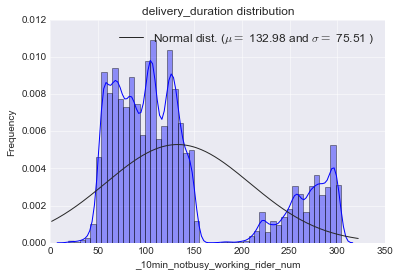

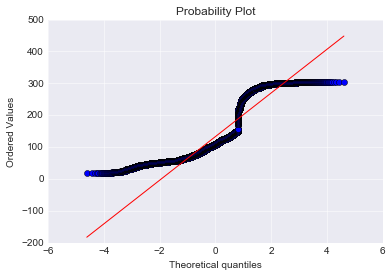

In [78]:
# train_sub = train_sub.loc[gene_mask(train_sub,11)]
train_sub =train_cv
sns.distplot(train_sub['_10min_notbusy_working_rider_num'] , fit=norm);
(mu, sigma) = norm.fit(train_sub['_10min_notbusy_working_rider_num'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('delivery_duration distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_sub['_10min_notbusy_working_rider_num'], plot=plt)
plt.show()


 mu = 4938.28 and sigma = 2260.38



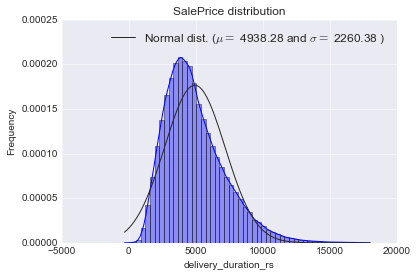

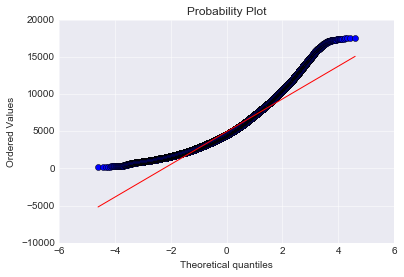

In [83]:
import math

train = train_sub
train["delivery_duration_rs"] = train["delivery_duration"].apply(lambda x:(1+x)**1.1)
sns.distplot(train['delivery_duration_rs'] , fit=norm)

#Check the new distribution 

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['delivery_duration_rs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['delivery_duration_rs'], plot=plt)
plt.show()

In [76]:
out_restack.describe()

,delivery_duration,order_id
count,251864.000000,2.518640e+05
mean,2239.970340,1.502431e+15
std,655.994086,5.682584e+11
min,1033.324179,1.501470e+15
25%,1711.153214,1.501926e+15
50%,2157.790644,1.502422e+15
75%,2711.686756,1.502940e+15
max,4063.646631,1.503397e+15


In [106]:
out_restack= out
out_restack['delivery_duration'] =(out_restack['delivery_duration'] - out_restack['delivery_duration'].mean()) + 2205.7

In [458]:
missing_values_table(train_cv)

,missing_values,missing_percent
Unnamed: 0,0,0.000000
order_id,0,0.000000
poi_id,0,0.000000
area_id_x,0,0.000000
food_total_value,0,0.000000
box_total_value,0,0.000000
food_num,0,0.000000
delivery_distance,0,0.000000
order_unix_time,0,0.000000
arriveshop_unix_time,0,0.000000


In [107]:
# missing_values_table(train_cv)

out_restack = out_restack[['order_id','delivery_duration']]

In [108]:
out = out_restack
out.describe()

,order_id,delivery_duration
count,2.518640e+05,251864.000000
mean,1.502431e+15,2205.700000
std,5.682584e+11,652.578534
min,1.501470e+15,1011.428738
25%,1.501926e+15,1678.328961
50%,1.502422e+15,2121.906949
75%,1.502940e+15,2673.311130
max,1.503397e+15,4016.453925


In [109]:
#out.columns = ['order_id','delivery_duration']
out.to_csv(input_path+"out.csv",header=["order_id","delivery_duration"],index=False)
out.describe()

,order_id,delivery_duration
count,2.518640e+05,251864.000000
mean,1.502431e+15,2205.700000
std,5.682584e+11,652.578534
min,1.501470e+15,1011.428738
25%,1.501926e+15,1678.328961
50%,1.502422e+15,2121.906949
75%,1.502940e+15,2673.311130
max,1.503397e+15,4016.453925


In [145]:
train_sub.head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,cur_min,next5_min,next10_min,cur_10_block,last_10_block,next_10_block,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_std_food_total_value,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_std_delivery_distance,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_std_food_total_value,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_std_delivery_distance,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_dict__food_total_value_last_ten,lasthour_poi_dict__fetch_cost,lasthour_poi_dict__arriveshop_cost,prd_arrive_guest_time,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_prd_arrive_guest_time_mean,area_id_area_id#hour#minute_prd_arrive_guest_time_std,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,delivery_duration_rs
0,0,1499050811135855,2829190,1003209,49.00,1.00,1.0,770.0,1499050800,1.499052e+09,1.499052e+09,1.499053e+09,163.389240,37.383810,163.392396,37.379690,6.0,2075.0,1499050800,3,0,11,0,0,660,675,690,66,65,67,0,1,11,127.0,101.0,98.0,46.0,0.0,29.422566,0.9,1.295918,0.455446,0.371084,-31.327297,37.380,163.392,37.384,163.389,863,330.0,882.0,0.873016,4.0,509.0,671.647770,763.0,2789.0,942.942424,47.542870,57.00,974.215939,1442.0,2.00,177.0,627.135500,1258.0,916.405980,0.561817,0.371410,1.780600,1.297946,4.0,69.0,732.0,628.216310,2313.0,762.645684,54.376529,54.00,805.557856,1712.0,2.00,474.130799,386.0,877.0,723.855501,0.707730,0.373917,1.983626,1.559122,77.25,972.25,456.25,432.438392,8092.07,944.826911,526.561133,816.5,660.443278,4456.050296
1,1,1499050826151533,2148908,1004986,39.00,2.00,1.0,522.0,1499050800,1.499051e+09,1.499051e+09,1.499052e+09,163.200664,37.424204,163.203345,37.425949,3.0,1039.0,1499050800,3,0,11,0,0,660,675,690,66,65,67,0,1,11,32.0,54.0,54.0,16.0,0.0,27.939822,1.8,0.592593,0.296296,0.502406,-129.336897,37.426,163.203,37.424,163.201,288,352.0,399.0,1.308271,1.0,130.0,288.635509,471.5,1695.5,656.753977,39.517671,67.50,551.942862,1145.0,3.00,225.5,499.737444,743.5,605.814656,0.668934,0.390402,2.184615,1.138020,0.0,19.0,519.0,227.074478,1625.0,263.943608,23.842686,77.00,754.434376,866.0,3.00,429.595029,407.0,618.0,396.382753,0.532923,0.454703,1.895277,0.944074,66.25,599.5

In [462]:
train_cv[(train_cv['poi_id'] == 2005890)&(train_cv.hour ==11)].sort_values("order_id")[['cur_area_busy_coef_y',"area_busy_coef","area_busy_coef_change"]]

KeyError: "['area_busy_coef_change'] not in index"

In [110]:
# person = train_cv[['delivery_duration','arriveshop_cost',"fetch_cost",'arrive_guest_cost',] +gene_xtrain(train_cv,["base","rolling_poi_bin","rolling_poi_fea","rolling_user_bin"])].corr()

person = train_sub.corr()

KeyboardInterrupt: 

In [56]:
person[['delivery_duration','arriveshop_cost',"fetch_cost",'arrive_guest_cost',]].sort_values("delivery_duration",ascending=False).head(100)


,delivery_duration,arriveshop_cost,fetch_cost,arrive_guest_cost
delivery_duration,1.000000,0.597330,0.203683,0.566943
high_level_arrive_guest##delivery_distance_1,0.616891,0.329521,-0.033786,0.541780
area_busy_coef,0.598114,0.546487,-0.067189,0.271574
arriveshop_cost,0.597330,1.000000,-0.371023,-0.025894
arrive_guest_cost,0.566943,-0.025894,-0.128983,1.000000
high_level_arrive_shop##not_fetched_area_busy,0.559187,0.510699,-0.063243,0.253106
bill_number_per_rider,0.522974,0.503299,-0.096542,0.239503
area_id_area_id#hour#minute_arriveshop_cost_std,0.505335,0.459339,-0.072727,0.246820
_10min_not_fetched_order_num,0.483141,0.359694,0.008791,0.265297
area_id_area_id#hour#minute_arriveshop_cost_mean,0.479198,0.478427,-0.105104,0.212762


In [57]:
person[person.delivery_duration>0.3].index

Index([u'waiting_order_num', u'delivery_duration',
       u'_10min_not_fetched_order_num', u'_10min_deliverying_order_num',
       u'area_busy_coef', u'bill_number_per_rider', u'arriveshop_cost',
       u'arrive_guest_cost', u'poi_agg_poi_id_mean_dd',
       u'poi_agg_poi_id_std_dd', u'poi_agg_poi_id_mean_arriveshop_cost',
       u'poi_agg_poi_id_std_arriveshop_cost',
       u'lasthour_poi_agg_poi_id_mean_dd', u'lasthour_poi_agg_poi_id_std_dd',
       u'area_id_area_id#hour#minute_food_total_value_sum',
       u'area_id_area_id#hour#minute_arriveshop_cost_mean',
       u'area_id_area_id#hour#minute_arriveshop_cost_std',
       u'prd_arrive_guest_time',
       u'high_level_arrive_shop##not_fetched_area_busy',
       u'high_level_arrive_shop##not_waited_div_not_working_rider',
       u'high_level_arrive_shop##waiting_plus_food_value_plus_box_value',
       u'high_level_arrive_guest##delivery_distance_1',
       u'high_level_arrive_guest##delivery_distance_2'],
      dtype='object')

In [60]:
person[['delivery_duration','arriveshop_cost',"fetch_cost",'arrive_guest_cost',]].sort_values("delivery_duration",ascending=False).head(20).index

Index([u'delivery_duration', u'high_level_arrive_guest##delivery_distance_1',
       u'area_busy_coef', u'arriveshop_cost', u'arrive_guest_cost',
       u'high_level_arrive_shop##not_fetched_area_busy',
       u'bill_number_per_rider',
       u'area_id_area_id#hour#minute_arriveshop_cost_std',
       u'_10min_not_fetched_order_num',
       u'area_id_area_id#hour#minute_arriveshop_cost_mean',
       u'poi_agg_poi_id_mean_dd',
       u'high_level_arrive_guest##delivery_distance_2',
       u'high_level_arrive_shop##waiting_plus_food_value_plus_box_value',
       u'_10min_deliverying_order_num', u'lasthour_poi_agg_poi_id_mean_dd',
       u'waiting_order_num', u'prd_arrive_guest_time',
       u'area_id_area_id#hour#minute_food_total_value_sum',
       u'poi_agg_poi_id_std_arriveshop_cost', u'poi_agg_poi_id_std_dd'],
      dtype='object')

In [61]:
rs = person.loc[[u'delivery_duration', u'high_level_arrive_guest##delivery_distance_1',
       u'area_busy_coef', u'arriveshop_cost', u'arrive_guest_cost',
       u'high_level_arrive_shop##not_fetched_area_busy',
       u'bill_number_per_rider',
       u'area_id_area_id#hour#minute_arriveshop_cost_std',
       u'_10min_not_fetched_order_num',
       u'area_id_area_id#hour#minute_arriveshop_cost_mean',
       u'poi_agg_poi_id_mean_dd',
       u'high_level_arrive_guest##delivery_distance_2',
       u'high_level_arrive_shop##waiting_plus_food_value_plus_box_value',
       u'_10min_deliverying_order_num', u'lasthour_poi_agg_poi_id_mean_dd',
       u'waiting_order_num', u'prd_arrive_guest_time',
       u'area_id_area_id#hour#minute_food_total_value_sum',
       u'poi_agg_poi_id_std_arriveshop_cost', u'poi_agg_poi_id_std_dd']]

In [62]:
import numpy as np
rs.applymap(lambda x: x if x>0.8  else np.nan)

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,cur_min,next15_min,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_std_food_total_value,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_std_delivery_distance,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_std_food_total_value,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_std_delivery_distance,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,prd_arrive_guest_time,high_level_arrive_shop##not_fetched_area_busy,high_level_arrive_shop##not_waited_div_not_working_rider,high_level_arrive_shop##waiting_plus_food_value_plus_box_value,high_level_arrive_guest##delivery_distance_1,high_level_arrive_guest##delivery_distance_2,high_level_arrive_guest##delivery_distance_5
delivery_duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
high_level_arrive_guest##delivery_distance_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
area_busy_coef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.850831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.933281,NaN,NaN,NaN,NaN,NaN
arriveshop_cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
train_cv.groupby('poi_id')['food_total_value'].rolling(2).mean()


In [113]:
from sklearn.datasets import dump_svmlight_file
to_drop = ['order_unix_time', 'arriveshop_unix_time', 'fetch_unix_time', 'finish_unix_time', 'order_id',
           'delivery_duration', 'date', "arriveshop_cost", "fetch_cost", "arrive_guest_cost", "tmp_order_unix_time",
           "coor_count_y", "coor_count_x",
           "coor_count",
           "avg_speed", "arrive_guest_avg_speed", 'high', 'day', "coor_count_x.1", "coor_count_y.1", "coor_count_y.2",
           'coor_count_x.2',
           "rain_bin", "wind_bin", "temperature_bin"
           ]
fea_drop = [
    "_10min_wind",
    # "area_id",
    "poi_id_mean_box_total_value",
    # "box_total_value",
    # "food_num",
    "_10min_rain",
    "weekday_hour",
    "_avg_speed_weekday",
    "minute",
    "_10min_temperature",
    "hour",
    "pickup_cluster",
    "dropoff_cluster",
    "next15_min",
    "cur_min_x",
    "cur_min_y",
    "cur_min"

    # "dropoff_cluster",
    # "delivery_distance",
    # "_10min_deliverying_order_num"
    # "poi_lat_bin","poi_lng_bin","cst_lat_bin","cst_lng_bin"
    # "poi_id",
    # "weekday",
    # "food_num",
    # "lasthour_poi_agg_poi_id_mean_delivery_distance"
]  # 407.263830991 all 400 # 407.263830991 all 400
for_drop = to_drop + fea_drop

In [114]:
path ="/Users/dongjian/data/meituanKaggleData/stack_train"
train_sub = train_sub.fillna(0)
label = train_sub['delivery_duration']
train = train_sub[train_sub.columns.difference(['delivery_duration']+for_drop)]
train.columns =  train.columns = [i for i in range(train.shape[1])]
dump_svmlight_file(train,label,path)

In [115]:
path ="/Users/dongjian/data/meituanKaggleData/stack_test"
test_sub = test_sub.fillna(0)
test_sub['delivery_duration'] = 0
label = test_sub['delivery_duration']
test = test_sub[test_sub.columns.difference(['delivery_duration'] + for_drop)]
test.columns =  test.columns = [i for i in range(train.shape[1])]
dump_svmlight_file(test,label,path)

In [146]:
train_sub['pickup_cluster'].head()

KeyError: 'pickup_cluster'

In [57]:
out = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/upload/cv_38_0.642026666667_my_preds.csv")


In [58]:
out.head()

,id,y
0,1499397673039892,1972.081055
1,1499223721135408,1841.880493
2,1500175035045803,2044.311035
3,1499572210126316,3933.241455
4,1500544773204347,1733.945557


In [59]:
test_cv['delivery_duration_prd'] = out['y']

In [60]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_cv["delivery_duration"], test_cv["delivery_duration_prd"])

413.10688225082447

In [107]:
test_cv.head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,pickup_cluster,dropoff_cluster,cluster_agg_pickup_cluster#dropoff_cluster_food_total_value_sum,cluster_agg_pickup_cluster#dropoff_cluster_arriveshop_cost_mean,cluster_agg_pickup_cluster#dropoff_cluster_arriveshop_cost_std,cluster_agg_pickup_cluster#dropoff_cluster_aarrive_guest_cost_mean,cluster_agg_pickup_cluster#dropoff_cluster_arrive_guest_cost_std,prd_arrive_guest_time,deliver_duration_prd
0,0,1499397673039892,3758247,1002435,38.01,0.0,1.0,2080.0,1499397660,1.499398e+09,1.499398e+09,1.499399e+09,163.516408,37.387636,163.496740,37.382970,2.0,1538.0,1499397660,7,4,11,2,1,21,1,107,320.0,145.0,145.0,199.0,0.0,29.215367,1.40,2.206897,1.372414,1.352406,73.369766,37.383,163.497,37.388,163.516,0.0,129.0,515.318487,727.0,1727.0,690.625710,27.040265,908.101797,2.0,133.0,282.901873,533.0,517.931504,1.240455,0.573921,2.545455,1.300315,0.0,31.0,817.0,465.956470,1552.0,503.099828,21.769324,744.912786,2.0,244.774177,116.0,486.0,254.394935,1.475016,0.462380,0.0,0.0,15906.60,1079.5,742.408478,70,12,2434.40,641.0,708.368516,721.0,341.671610,817.142857,2013.28
1,1,1499223721135408,1016767,1002483,36.50,1.5,1.0,653.0,1499223677,1.499224e+09,1.499224e+09,1.499225e+09,163.575828,37.480940,163.577416,37.477188,4.0,890.0,1499223677,5,2,11,0,0,1,1,59,574.0,279.0,279.0,195.0,0.0,29.435614,1.10,2.057348,0.698925,0.733708,-18.565365,37.477,163.577,37.481,163.576,2.0,339.0,667.333871,1005.0,2245.0,889.566718,18.903675,827.331501,1.5,310.0,314.697255,515.0,784.058087,0.769311,0.419800,1.585816,2.117033,1.0,56.0,855.5,546.465977,1832.5,653.430591,27.067267,808.943274,1.5,397.525670,535.0,240.0,374.557363,0.916115,0.453843,0.0,0.0,31516.70,448.0,615.713509,19,19,140388.34,707.0,838.174634,494.0,426.404620,411.775337,1819.10
2,2,1500175035045803,1765865,1003189,71.50,4.0,1.0,2158.0,1500175012,1.500175e+09,1.500176e+09,1.500177e+09,163.610384,37.348851,163.597570,37.356234,3.0,1880.0,1500175012,16,6,11,1,1,16,1,155,192.0,135.0,134.0,105.0,0.0,31.588614,1.20,1.43

In [110]:
test_cv.columns


Index([u'Unnamed: 0', u'order_id', u'poi_id', u'area_id', u'food_total_value',
       u'box_total_value', u'food_num', u'delivery_distance',
       u'order_unix_time', u'arriveshop_unix_time', u'fetch_unix_time',
       u'finish_unix_time', u'customer_longitude', u'customer_latitude',
       u'poi_lng', u'poi_lat', u'waiting_order_num', u'delivery_duration',
       u'tmp_order_unix_time', u'day', u'weekday', u'hour', u'10min', u'15min',
       u'minute', u'high', u'weekday_hour', u'_10min_not_fetched_order_num',
       u'_10min_working_rider_num', u'_10min_notbusy_working_rider_num',
       u'_10min_deliverying_order_num', u'_10min_rain', u'_10min_temperature',
       u'_10min_wind', u'area_busy_coef', u'bill_number_per_rider',
       u'avg_speed', u'direction', u'poi_lat_bin', u'poi_lng_bin',
       u'cst_lat_bin', u'cst_lng_bin',
       u'poi_agg_poi_id_mean_waiting_order_num', u'poi_agg_poi_id_coor_count',
       u'poi_agg_poi_id_std_arrive_guest_cost',
       u'poi_agg_poi_id_mean_

In [147]:
train_cv.head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,pickup_cluster,dropoff_cluster,cluster_agg_dropoff_cluster_food_total_value_sum,cluster_agg_dropoff_cluster_arriveshop_cost_std,cluster_agg_dropoff_cluster_arriveshop_cost_mean,cluster_agg_dropoff_cluster_arrive_guest_cost_std,cluster_agg_dropoff_cluster_aarrive_guest_cost_mean,prd_arrive_guest_time
0,0,1499831891055817,2005890,1002435,34.9,0.0,1.0,1451.0,1499831777,1.499833e+09,1.499833e+09,1.499835e+09,163.517332,37.385954,163.531618,37.385045,1.0,3068.0,1499831777,12,2,11,5,3,56,1,59,557.0,119.0,119.0,310.0,0.0,33.255934,2.20,4.680672,2.605042,0.472947,-85.417209,37.385,163.532,37.386,163.517,1083,95.0,1890.0,0.767725,1.0,207.0,468.353926,717.0,1715.0,546.398977,28.853241,712.688226,0.0,363.0,350.856066,395.0,413.455505,0.831781,0.422065,1.985075,1.142357,1.0,57.0,692.0,349.312392,1655.0,417.469044,24.406162,784.678583,0.0,290.880454,278.0,380.0,394.406297,0.895680,0.502755,2.042353,0.975647,11757.50,1256.0,751.915208,184,377,77201.12,757.402555,737.0,439.907776,558.5,730.954887
1,1,1499418694077256,1108097,1002568,38.9,0.0,1.0,1164.0,1499418682,1.499419e+09,1.499420e+09,1.499420e+09,163.459204,37.469835,163.451589,37.473112,2.0,1259.0,1499418682,7,4,17,1,0,11,1,113,48.0,70.0,69.0,19.0,0.0,33.255934,2.20,0.695652,0.271429,0.924543,118.465036,37.473,163.452,37.470,163.459,339,509.0,411.0,2.832117,1.0,262.0,334.224093,570.0,1777.0,603.091676,42.114457,648.303842,0.0,590.5,427.144538,458.0,642.994391,0.747637,0.376511,2.447260,2.051632,1.0,47.0,514.0,423.465747,1920.0,492.059630,39.918429,690.116425,0.0,500.904627,690.0,513.0,384.331392,0.851344,0.404849,3.042857,1.721664,2841.20,362.0,363.122769,33,418,37335.30,722.211999,553.5,404.651041,444.5,475.634049
2,2,1500978428196399,1387870,1002483,35.0,1.0,1.0,2146.0,1500978406,1.500979e+09,1.500979e+09,1.500980e+09,163.590656,37.474560,163.577850,37.487120,3.0,1610.0,1500978406,25,1,18,2,1,26,1,42,138.0,271.0,271.0,166.

In [151]:
train_cv.drop(["poi_id"],axis=1)

KeyboardInterrupt: 

In [ ]:
train_cv.head()

In [167]:
from sklearn.ensemble import IsolationForest

tr =train_cv
iso = IsolationForest(n_estimators=100, contamination=0.1, n_jobs=4)
ttr = tr.fillna(0)
iso.fit(ttr[[
                  "delivery_distance",
                  "delivery_duration",
                  ] ])
tr["iso"] = iso.predict(ttr)
print "tr lenthg {}, after outline {}".format(len(tr), len(tr[tr.iso != 1]))
tr = tr[tr.iso != 1]


tr lenthg 325437, after outline 325437


In [169]:
tr['iso'].describe()

count    325437.0
mean         -1.0
std           0.0
min          -1.0
25%          -1.0
50%          -1.0
75%          -1.0
max          -1.0
Name: iso, dtype: float64

In [165]:
tr.head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,prd_arrive_guest_time,iso


In [26]:
train_cv.head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,prd_arrive_guest_time
0,0,1499831891055817,2005890,1002435,34.9,0.0,1.0,1451.0,1499831777,1.499833e+09,1.499833e+09,1.499835e+09,163.517332,37.385954,163.531618,37.385045,1.0,3068.0,1499831777,12,2,11,5,3,56,1,59,557.0,119.0,119.0,310.0,NaN,NaN,NaN,4.680672,2.605042,0.472947,-85.417209,37.385,163.532,37.386,163.517,1083,95.0,1890.0,0.767725,1.0,207.0,468.353926,717.0,1715.0,546.398977,28.853241,712.688226,0.0,363.0,350.856066,395.0,413.455505,0.831781,0.422065,1.985075,1.142357,1.0,57.0,692.0,349.312392,1655.0,417.469044,24.406162,784.678583,0.0,290.880454,278.0,380.0,394.406297,0.895680,0.502755,2.042353,0.975647,11757.50,1256.0,751.915208,730.954887
1,1,1499418694077256,1108097,1002568,38.9,0.0,1.0,1164.0,1499418682,1.499419e+09,1.499420e+09,1.499420e+09,163.459204,37.469835,163.451589,37.473112,2.0,1259.0,1499418682,7,4,17,1,0,11,1,113,48.0,70.0,69.0,19.0,0.0,33.255934,2.20,0.695652,0.271429,0.924543,118.465036,37.473,163.452,37.470,163.459,339,509.0,411.0,2.832117,1.0,262.0,334.224093,570.0,1777.0,603.091676,42.114457,648.303842,0.0,590.5,427.144538,458.0,642.994391,0.747637,0.376511,2.447260,2.051632,1.0,47.0,514.0,423.465747,1920.0,492.059630,39.918429,690.116425,0.0,500.904627,690.0,513.0,384.331392,0.851344,0.404849,3.042857,1.721664,2841.20,362.0,363.122769,475.634049
2,2,1500978428196399,1387870,1002483,35.0,1.0,1.0,2146.0,1500978406,1.500979e+09,1.500979e+09,1.500980e+09,163.590656,37.474560,163.577850,37.487120,3.0,1610.0,1500978406,25,1,18,2,1,26,1,42,138.0,271.0,271.0,166.0,0.0,29.037631,1.65,0.509225,0.612546,1.332919,141.019800,37.487,163.578,37.475,163.591,422,425.0,763.0,2.812582,2.0,399.0,608.214590,1041.0,2487.0,893.637846,16.649849,811.685310,2.0,503.0,539.247464,551.0,787.255269,0.738250,0.393332,1.757282,2.959921,2.0,111.0,926.0,556.139149,1929.0,637.365495,34.713450,846.737170,2.0,461.105901,557.0,157.0,276.268881,0.976963,0.421977,1.890063,4

In [133]:
#for restack
tr = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/stack_data/train2018.csv")
te = pd.read_csv("/Users/dongjian/work/meituan/instacart/solutions/meituan_lasthour/stack/regression/stack_data/test2018.csv")
f_tr = pd.concat([train_sub,tr],axis=1)
f_te = pd.concat([test_sub,te],axis=1)





In [134]:
f_tr.head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,prd_arrive_guest_time,xgb5,xgb8,xgb10,lgb3,lgb8,lgb5,rf,ada,gb,et,le,el
0,0,1499050811135855,2829190,1003209,49.00,1.00,1.0,770.0,1499050800,1.499052e+09,1.499052e+09,1.499053e+09,163.389240,37.383810,163.392396,37.379690,6.0,2075.0,1499050800,3,0,11,0,0,0,1,11,127.0,101.0,98.0,46.0,0.0,29.422566,0.9,1.295918,0.455446,0.371084,-31.327297,37.380,163.392,37.384,163.389,863,330.0,882.0,0.873016,4.0,933.0,587.452379,729.0,2549.0,806.301980,48.889440,961.741326,2.0,195.0,554.977823,1156.0,810.086839,0.607709,0.384647,1.840514,1.315610,4.0,144.0,787.5,560.761252,2469.5,667.277005,48.101142,850.849588,2.00,612.290332,374.5,846.0,717.877972,0.751111,0.357874,2.140691,1.469245,16937.26,734.0,619.033690,418.361286,1894.232300,1951.790161,1932.235229,1957.885090,1953.224663,2046.219047,1759.351472,2262.663870,2004.108047,2162.090855,1916.786669,1982.832442
1,1,1499050826151533,2148908,1004986,39.00,2.00,1.0,522.0,1499050800,1.499051e+09,1.499051e+09,1.499052e+09,163.200664,37.424204,163.203345,37.425949,3.0,1039.0,1499050800,3,0,11,0,0,0,1,11,32.0,54.0,54.0,16.0,0.0,27.939822,1.8,0.592593,0.296296,0.502406,-129.336897,37.426,163.203,37.424,163.201,288,352.0,399.0,1.308271,1.0,275.0,258.050762,473.0,1649.0,542.120949,45.814048,553.597435,3.0,246.0,458.544309,706.0,527.794626,0.672485,0.360897,2.176119,1.055879,0.0,41.0,516.0,218.193950,1625.0,301.298442,32.711283,661.053884,3.00,373.004219,606.0,367.0,396.639478,0.742686,0.384724,2.376359,0.960185,7494.13,543.5,405.360762,239.876543,1372.977051,1479.887573,1494.154907,1371.492693,1281.154500,1335.901313,1349.079951,1736.598343,1602.328360,1735.570739,1179.957148,1362.383202
2,2,1499050952065548,1602946,1002430,36.75,2.25,1.0,1290.0,1499050803,1.499051e+09,1.499052e+09,1.499052e+09,163.575730,37.356075,163.569193,37.349766,0.0,1235.0,1499050803,3,0,11,0,0,0,1,11,41.0,76.0,76.0,21.0,0.0,28.683300,0.9,0.539474,0.276316,1.044534,39

In [135]:
f_tr.to_csv(input_path + "train_restack.csv")
f_te.to_csv(input_path + "test_restack.csv")

In [234]:
train_sub.describe()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,minute,cur_min_x,next15_min,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,arriveshop_cost,fetch_cost,arrive_guest_cost,arrive_guest_avg_speed,poi_agg_poi_id_mean_waiting_order_num,poi_agg_poi_id_coor_count,poi_agg_poi_id_std_arrive_guest_cost,poi_agg_poi_id_mean_arrive_guest_cost,poi_agg_poi_id_mean_dd,poi_agg_poi_id_std_dd,poi_agg_poi_id_std_food_total_value,poi_agg_poi_id_mean_food_total_value,poi_agg_poi_id_std_delivery_distance,poi_agg_poi_id_mean_delivery_distance,poi_agg_poi_id_mean_box_total_value,poi_agg_poi_id_mean_fetch_cost,poi_agg_poi_id_std_fetch_cost,poi_agg_poi_id_mean_arriveshop_cost,poi_agg_poi_id_std_arriveshop_cost,poi_agg__avg_speed_meanpoi_id,poi_agg__avg_speed_stdpoi_id,poi_agg_poi_id_arrive_guest_avg_speed_mean,poi_agg_poi_id_arrive_guest_avg_speed_std,lasthour_poi_agg_poi_id_mean_waiting_order_num,lasthour_poi_agg_poi_id_coor_count,lasthour_poi_agg_poi_id_mean_arrive_guest_cost,lasthour_poi_agg_poi_id_std_arrive_guest_cost,lasthour_poi_agg_poi_id_mean_dd,lasthour_poi_agg_poi_id_std_dd,lasthour_poi_agg_poi_id_std_food_total_value,lasthour_poi_agg_poi_id_mean_food_total_value,lasthour_poi_agg_poi_id_std_delivery_distance,lasthour_poi_agg_poi_id_mean_delivery_distance,lasthour_poi_agg_poi_id_mean_box_total_value,lasthour_poi_agg_poi_id_std_fetch_cost,lasthour_poi_agg_poi_id_mean_fetch_cost,lasthour_poi_agg_poi_id_mean_arriveshop_cost,lasthour_poi_agg_poi_id_std_arriveshop_cost,lasthour_poi_agg__avg_speed_meanpoi_id,lasthour_poi_agg__avg_speed_stdpoi_id,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_mean,lasthour_poi_agg_poi_id_arrive_guest_avg_speed_std,area_id_area_id#hour#minute_food_total_value_sum,area_id_area_id#hour#minute_arriveshop_cost_mean,area_id_area_id#hour#minute_arriveshop_cost_std,prd_arrive_guest_time,cur_min_y,cur_10min_working_rider_last,cur_10min_deliverying_order_num,cur_10min_not_fetched_order_num,cur_10min_notbusy_working_rider_median
count,659269.000000,6.592690e+05,6.592690e+05,6.592690e+05,659269.000000,659269.000000,659268.000000,659269.000000,6.592690e+05,6.592690e+05,6.592690e+05,6.592690e+05,659269.000000,659269.000000,659269.000000,659269.000000,659268.000000,659269.000000,6.592690e+05,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.0,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,517411.000000,517411.000000,517411.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,657193.000000,642976.000000,642976.000000,642976.000000,640817.000000,642976.000000,640817.000000,640817.000000,642976.000000,640817.000000,642976.000000,642976.000000,640817.000000,642976.000000,642976.000000,640817.000000,642976.000000,640817.000000,642976.000000,640817.000000,659269.000000,659269.000000,659269.000000,657193.000000,659269.000000,659269.000000,659269.000000,659269.000000,659269.000000
mean,329634.000000,1.500232e+15,1.998585e+06,1.002844e+06,64.084601,2.405560,1.127179,1646.050629,1.500232e+09,1.500232e+09,1.500233e+09,1.500234e+09,163.511554,37.434614,163.511375,37.434929,4.771494,2139.660547,1.500232e+09,

In [237]:
train_sub[["cur_min_x","next15_min","_10min_not_fetched_order_num","cur_10min_not_fetched_order_num"]].head()

,cur_min_x,next15_min,_10min_not_fetched_order_num,cur_10min_not_fetched_order_num
0,660,675,127.0,206.5
1,660,675,32.0,69.0
2,660,675,41.0,93.0
3,660,675,218.0,343.0
4,660,675,218.0,343.0


In [379]:
rs = [
    pd.read_csv(input_path+"out_regression_256_1500.csv",sep=',')
,pd.read_csv(input_path+"out_regression_512_1200.csv",sep=',')
,pd.read_csv(input_path+"out_regression_256_2000.csv",sep=',')
# ,pd.read_csv(input_path+"out_huber_256_2000.csv",sep=',')
# ,pd.read_csv(input_path+"out_regression_l1_256_1200.csv",sep=',')
,pd.read_csv(input_path+"out_regression_64_1200.csv",sep=',')
,pd.read_csv(input_path+"out_poisson_256_1200.csv",sep=',')
# ,pd.read_csv(input_path+"out_fair_256_1200.csv",sep=',')
,pd.read_csv(input_path+"out_regression_1024_1200.csv",sep=',')
# ,pd.read_csv(input_path+"last_out.csv",sep=',')
]


In [382]:
map(lambda x:[x['delivery_duration'].std(),x['delivery_duration'].mean()],rs)

[[653.1245616206699, 2202.9999999999277],
 [651.1173996431248, 2203.0000000000605],
 [653.6569035616453, 2202.9999999999563],
 [651.7244061744029, 2203.000000000008],
 [650.4883220711729, 2202.999999999984],
 [651.6966627460331, 2203.0000000000164]]

In [381]:
def get_mean(x):
    x['delivery_duration'] = x['delivery_duration'] - x['delivery_duration'].mean() + 2203
    return x
rm = map(get_mean,rs)

In [373]:
map(lambda x:x['delivery_duration'].mean(),rs)

[2203.0000000000605, 2203.000000000912]

In [383]:
a = (rs[0]["delivery_duration"] + rs [1]["delivery_duration"]
    +rs [2]["delivery_duration"]+rs [3]["delivery_duration"]
    +rs [4]["delivery_duration"]+rs [5]["delivery_duration"])/6

In [384]:
b = rs[0].copy()
b['delivery_duration'] =a 


In [366]:
rs[0]['delivery_duration'] =  rs[0]['delivery_duration'] - 2240 + 2203

In [385]:
b.to_csv(input_path+"out.csv",header=['order_id', 'delivery_duration'],index=False)

In [386]:
b.describe()

,order_id,delivery_duration
count,2.518640e+05,251864.000000
mean,1.502431e+15,2203.000000
std,5.682584e+11,651.289336
min,1.501470e+15,869.043078
25%,1.501926e+15,1679.641530
50%,1.502422e+15,2119.568432
75%,1.502940e+15,2676.441637
max,1.503397e+15,4324.982193


In [368]:
rs[0].to_csv(input_path+"out.csv",header=['order_id', 'delivery_duration'],index=False)

In [30]:
test_cv[["arriveshop_cost", "fetch_cost", "arrive_guest_cost","delivery_duration"]][test_cv.delivery_duration > 5000].head(100)

,arriveshop_cost,fetch_cost,arrive_guest_cost,delivery_duration


In [21]:
test_cv[test_cv.area_id == 1002435].head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,cur_min,next5_min,next10_min,cur_10_block,last_10_block,next_10_block,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,poi_agg__arrive_guest_avg_speed__mean_by__poi_id,poi_agg__arrive_guest_avg_speed__median_by__poi_id,poi_agg__arrive_guest_avg_speed__std_by__poi_id,poi_agg__avg_speed__mean_by__poi_id,poi_agg__avg_speed__median_by__poi_id,poi_agg__avg_speed__std_by__poi_id,poi_agg__delivery_duration__mean_by__poi_id,poi_agg__delivery_duration__median_by__poi_id,poi_agg__delivery_duration__std_by__poi_id,poi_agg__arriveshop_cost__mean_by__poi_id,poi_agg__arriveshop_cost__median_by__poi_id,poi_agg__arriveshop_cost__std_by__poi_id,poi_agg__arrive_guest_cost__mean_by__poi_id,poi_agg__arrive_guest_cost__median_by__poi_id,poi_agg__arrive_guest_cost__std_by__poi_id,poi_agg__fetch_cost__mean_by__poi_id,poi_agg__fetch_cost__median_by__poi_id,poi_agg__fetch_cost__std_by__poi_id,poi_agg__delivery_distance__mean_by__poi_id,poi_agg__delivery_distance__median_by__poi_id,poi_agg__delivery_distance__std_by__poi_id,poi_agg__food_total_value__mean_by__poi_id,poi_agg__food_total_value__median_by__poi_id,poi_agg__food_total_value__std_by__poi_id,poi_agg__box_total_value__mean_by__poi_id,poi_agg__box_total_value__median_by__poi_id,poi_agg__box_total_value__std_by__poi_id,poi_agg__waiting_order_num__mean_by__poi_id,poi_agg__waiting_order_num__median_by__poi_id,poi_agg__waiting_order_num__std_by__poi_id,poi_agg__order_id__count_by__poi_id,lasthour_poi_agg__arrive_guest_avg_speed__mean_by__poi_id,lasthour_poi_agg__arrive_guest_avg_speed__median_by__poi_id,lasthour_poi_agg__arrive_guest_avg_speed__std_by__poi_id,lasthour_poi_agg__avg_speed__mean_by__poi_id,lasthour_poi_agg__avg_speed__median_by__poi_id,lasthour_poi_agg__avg_speed__std_by__poi_id,lasthour_poi_agg__delivery_duration__mean_by__poi_id,lasthour_poi_agg__delivery_duration__median_by__poi_id,lasthour_poi_agg__delivery_duration__std_by__poi_id,lasthour_poi_agg__arriveshop_cost__mean_by__poi_id,lasthour_poi_agg__arriveshop_cost__median_by__poi_id,lasthour_poi_agg__arriveshop_cost__std_by__poi_id,lasthour_poi_agg__arrive_guest_cost__mean_by__poi_id,lasthour_poi_agg__arrive_guest_cost__median_by__poi_id,lasthour_poi_agg__arrive_guest_cost__std_by__poi_id,lasthour_poi_agg__fetch_cost__mean_by__poi_id,lasthour_poi_agg__fetch_cost__median_by__poi_id,lasthour_poi_agg__fetch_cost__std_by__poi_id,lasthour_poi_agg__delivery_distance__mean_by__poi_id,lasthour_poi_agg__delivery_distance__median_by__poi_id,lasthour_poi_agg__delivery_distance__std_by__poi_id,lasthour_poi_agg__food_total_value__mean_by__poi_id,lasthour_poi_agg__food_total_value__median_by__poi_id,lasthour_poi_agg__food_total_value__std_by__poi_id,lasthour_poi_agg__box_total_value__mean_by__poi_id,lasthour_poi_agg__box_total_value__median_by__poi_id,lasthour_poi_agg__box_total_value__std_by__poi_id,lasthour_poi_agg__waiting_order_num__mean_by__poi_id,lasthour_poi_agg__waiting_order_num__median_by__poi_id,lasthour_poi_agg__waiting_order_num__std_by__poi_id,lasthour_poi_agg__order_id__count_by__poi_id,lasthour_poi_dict__food_total_value_last_ten,lasthour_poi_dict__fetch_cost,lasthour_poi_dict__arriveshop_cost,prd_arrive_guest_time,area_agg__prd_arrive_guest_time__median_by__area_id#hour#minute,area_agg__prd_arrive_guest_time__std_by__area_id#hour#minute,area_agg__arriveshop_cost__median_by__area_id#hour#minute,area_agg__arriveshop_cost__std_by__area_id#hour#minute,area_agg__order_id__count_by__area_id#hour#min

In [23]:
test_cv[test_cv._10min_working_rider_num - test_cv._10min_notbusy_working_rider_num > 10].head()

,Unnamed: 0,order_id,poi_id,area_id,food_total_value,box_total_value,food_num,delivery_distance,order_unix_time,arriveshop_unix_time,fetch_unix_time,finish_unix_time,customer_longitude,customer_latitude,poi_lng,poi_lat,waiting_order_num,delivery_duration,tmp_order_unix_time,day,weekday,hour,10min,15min,cur_min,next5_min,next10_min,cur_10_block,last_10_block,next_10_block,minute,high,weekday_hour,_10min_not_fetched_order_num,_10min_working_rider_num,_10min_notbusy_working_rider_num,_10min_deliverying_order_num,_10min_rain,_10min_temperature,_10min_wind,area_busy_coef,bill_number_per_rider,avg_speed,direction,poi_lat_bin,poi_lng_bin,cst_lat_bin,cst_lng_bin,poi_agg__arrive_guest_avg_speed__mean_by__poi_id,poi_agg__arrive_guest_avg_speed__median_by__poi_id,poi_agg__arrive_guest_avg_speed__std_by__poi_id,poi_agg__avg_speed__mean_by__poi_id,poi_agg__avg_speed__median_by__poi_id,poi_agg__avg_speed__std_by__poi_id,poi_agg__delivery_duration__mean_by__poi_id,poi_agg__delivery_duration__median_by__poi_id,poi_agg__delivery_duration__std_by__poi_id,poi_agg__arriveshop_cost__mean_by__poi_id,poi_agg__arriveshop_cost__median_by__poi_id,poi_agg__arriveshop_cost__std_by__poi_id,poi_agg__arrive_guest_cost__mean_by__poi_id,poi_agg__arrive_guest_cost__median_by__poi_id,poi_agg__arrive_guest_cost__std_by__poi_id,poi_agg__fetch_cost__mean_by__poi_id,poi_agg__fetch_cost__median_by__poi_id,poi_agg__fetch_cost__std_by__poi_id,poi_agg__delivery_distance__mean_by__poi_id,poi_agg__delivery_distance__median_by__poi_id,poi_agg__delivery_distance__std_by__poi_id,poi_agg__food_total_value__mean_by__poi_id,poi_agg__food_total_value__median_by__poi_id,poi_agg__food_total_value__std_by__poi_id,poi_agg__box_total_value__mean_by__poi_id,poi_agg__box_total_value__median_by__poi_id,poi_agg__box_total_value__std_by__poi_id,poi_agg__waiting_order_num__mean_by__poi_id,poi_agg__waiting_order_num__median_by__poi_id,poi_agg__waiting_order_num__std_by__poi_id,poi_agg__order_id__count_by__poi_id,lasthour_poi_agg__arrive_guest_avg_speed__mean_by__poi_id,lasthour_poi_agg__arrive_guest_avg_speed__median_by__poi_id,lasthour_poi_agg__arrive_guest_avg_speed__std_by__poi_id,lasthour_poi_agg__avg_speed__mean_by__poi_id,lasthour_poi_agg__avg_speed__median_by__poi_id,lasthour_poi_agg__avg_speed__std_by__poi_id,lasthour_poi_agg__delivery_duration__mean_by__poi_id,lasthour_poi_agg__delivery_duration__median_by__poi_id,lasthour_poi_agg__delivery_duration__std_by__poi_id,lasthour_poi_agg__arriveshop_cost__mean_by__poi_id,lasthour_poi_agg__arriveshop_cost__median_by__poi_id,lasthour_poi_agg__arriveshop_cost__std_by__poi_id,lasthour_poi_agg__arrive_guest_cost__mean_by__poi_id,lasthour_poi_agg__arrive_guest_cost__median_by__poi_id,lasthour_poi_agg__arrive_guest_cost__std_by__poi_id,lasthour_poi_agg__fetch_cost__mean_by__poi_id,lasthour_poi_agg__fetch_cost__median_by__poi_id,lasthour_poi_agg__fetch_cost__std_by__poi_id,lasthour_poi_agg__delivery_distance__mean_by__poi_id,lasthour_poi_agg__delivery_distance__median_by__poi_id,lasthour_poi_agg__delivery_distance__std_by__poi_id,lasthour_poi_agg__food_total_value__mean_by__poi_id,lasthour_poi_agg__food_total_value__median_by__poi_id,lasthour_poi_agg__food_total_value__std_by__poi_id,lasthour_poi_agg__box_total_value__mean_by__poi_id,lasthour_poi_agg__box_total_value__median_by__poi_id,lasthour_poi_agg__box_total_value__std_by__poi_id,lasthour_poi_agg__waiting_order_num__mean_by__poi_id,lasthour_poi_agg__waiting_order_num__median_by__poi_id,lasthour_poi_agg__waiting_order_num__std_by__poi_id,lasthour_poi_agg__order_id__count_by__poi_id,lasthour_poi_dict__food_total_value_last_ten,lasthour_poi_dict__fetch_cost,lasthour_poi_dict__arriveshop_cost,prd_arrive_guest_time,area_agg__prd_arrive_guest_time__median_by__area_id#hour#minute,area_agg__prd_arrive_guest_time__std_by__area_id#hour#minute,area_agg__arriveshop_cost__median_by__area_id#hour#minute,area_agg__arriveshop_cost__std_by__area_id#hour#minute,area_agg__order_id__count_by__area_id#hour#min